# Scraping Raw Data From Stack Overflow

Systematically extracting business intelligence from data.

In [1]:
# # get inline, interactivate plots
# %matplotlib inline

# # https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
# %load_ext autoreload
# %autoreload 2 

# Step 1: What is our question?

Essentially: What are the biggest problem areas for Python programmers?

# Step 2: Identify the data (Stack Overflow)

Data Source: All the questions on Stack Overflow that have the "Python" tag on them.

Question: Where exactly does all of this data live -- what is the URL structure we can use to 
acquire all of this user data?

Task: Work the URL into a formattable string template you can feed into a scraper.

In [2]:
SO_URL = "https://stackoverflow.com/questions/tagged/python?page={0}&sort=frequent&pagesize=50"

## Acquire the raw data

In [3]:
number_of_pages_to_gather = 50

# create sequence of page
page_range = range(1, number_of_pages_to_gather + 1)

So you may have noticed when we were formatting the URL that there are actually 1000s of pages of Python questions,
but here we're only collecting 50. This is intentional and temporary. Eventually we should collect the entire corpus of data, but right now we are trying to prototype a workflow.  So we are going to temporarily **downsample** to more rapidly prototype.

As a matter of fact, 50 is pretty high.  Let's kick it down to 5 files.  That way, we are still coding with the for conditions where we need to take multiple files (as opposed to just one), but not introducing lots of computing time.

In [4]:
page_range = range(1, 6)  
print(page_range)

[1, 2, 3, 4, 5]


In [5]:
# TODO: MAKE A PAGE URLS GENERATOR (argument: array of numbers, yields URLs )

In [6]:
import requests 

def http_get (URL):
    response = requests.get(URL)
    return response

# 
#  Once you have the data, it can be helpful to comment the following loop out.
# 
for i in page_range:
    so_response = http_get(SO_URL.format(i))
    
    if so_response.status_code == 200:
        html_file = open('data/FILENAME_00{0}.html'.format(i),'w')
        html_file.write(so_response.text.encode('ascii', 'ignore'))
        html_file.close()
    else:
        print("Failed at loop: ", i)

## Mash Until No Good! Data Munging/Wrangling/Cleansing

> Bad programmers worry about the code. 
>
> Good programmers worry about data structures and their relationships.
>
> Linus Torvalds, creator of Linux and git

> I be in the kitchen whipping
>
> trying to cook the sauce.
>
>   Yo Gotti, _The Art of the Hustle_

We are not going to begin whipping this data into shape for various levels of analysis - it's hard to do 
analysis on a bunch of data locked up in an HTML structure though.  

#### Extracting the maximum number of dimensions from the data

Look at the stack overflow page and think about what our granular data points are.  For the pages
we have decided to 

< INSERT PICTURE OF SO PAGE HERE >

The granular logical data point is a question.  So what are the dimensions/attributes of a question object?
- question text
- vote score
- views 
- details
- author
- question details 

Beautiful soup parses the HTML into a Python tree structure (DOM).  You can then use a variety of BS4 methods to extract specific HTML elements based on HTML attritbute.  Since classes and IDs are HTML attributes, you can use CSS selectors to extract information.

In [7]:
# insert quick BS4 demo before doing the real code in the next block

OK, let's actually get the question text, vote score, views, etc. out of the data.

In [8]:
from bs4 import BeautifulSoup

In [9]:
for i in page_range:
    file_name = 'data/FILENAME_00{0}.html'.format(i)
    print(file_name)
    
    with open(file_name,'r') as f:
        soup = BeautifulSoup(f.read(), 'html.parser')
        
        # for each file, get all of the question objects
        questions = soup.find_all("div", class_="question-summary")
        
        for question in questions:
            text = question.find('a', class_="question-hyperlink").text
            tags = [tag.text for tag in question.find_all('a', class_="post-tag")]
            views = int(question.find('div', class_="views")['title'].split(" ")[0].replace(",", ""))
#             print(tags)
        
    
        
        

data/FILENAME_001.html
data/FILENAME_002.html
data/FILENAME_003.html
data/FILENAME_004.html
data/FILENAME_005.html


OK, so we have figured out how to get at the data with Beautiful Soup above.  Let's wrap all of that logic into a **function** that accepts an HTML file as an argument and returns a sequence of question objects -- each object will contain all of the attributes.  Each of these will become a row in a Pandas DataFrame.

In [10]:
def get_question_info_from_summary(summary_div):
    qid = summary_div['id'].split("-")[2]
    text = summary_div.find('a', class_="question-hyperlink").text
    tags = [tag.text for tag in summary_div.find_all('a', class_="post-tag")]
    views = int(summary_div.find('div', class_="views")['title'].split(" ")[0].replace(",", ""))
    votes = int(summary_div.find('span', class_="vote-count-post").find('strong').text)

    # data isn't always there
    date = summary_div.find('span', class_='relativetime')
    date_asked = date['title'] if date else None
    
    return [qid, views, text, tags, date_asked, votes]


def extract_question_objects(relative_html_path):
    """
        :relative_html_path: file to read and parse for stack overflow questions
    """
    questions_objects = []
    with open(relative_html_path, 'r') as f:
    
        soup = BeautifulSoup(f.read(), 'html.parser')
        question_divs = soup.find_all("div", class_="question-summary")

        for question in question_divs:
                q_info = get_question_info_from_summary(question)
                questions_objects.append(q_info)
    
    
    return questions_objects

In [11]:
dataset = []

for i in page_range:
    filename = "data/FILENAME_00{}.html".format(i)
    qs = extract_question_objects(filename)
    dataset.extend(qs)


print(len(dataset))

250


We now have some structured data to play with.

In [12]:
print(dataset[0])

[u'1132941', 103681, u'\u201cLeast Astonishment\u201d and the Mutable Default Argument', [u'python', u'language-design', u'least-astonishment'], u'2009-07-15 18:00:37Z', 1893]


And the data doesn't look very "raw" anymore.  It's time to explore.

## Exploratory Data Analysis

pandas is a Python package providing fast, flexible, and expressive data structures designed to make working with “relational” or “labeled” data both easy and intuitive. It aims to be the fundamental high-level building block for doing practical, real world data analysis in Python. Additionally, it has the broader goal of becoming the most powerful and flexible open source data analysis / manipulation tool available in any language. It is already well on its way toward this goal.

The `DataFrame` is  the primary Pandas data structure.  They are great for exploring about tabular data - think columns and rows.

In [13]:
import pandas as pd
import numpy as np

# create columns
df = pd.DataFrame(columns=['views', 'text', 'tags', 'date_asked', 'votes'] )

# create rows/records
for data in dataset:
    qid, views, text, tags, date_asked, votes = data
    df.loc[qid] = [views, text, tuple(np.array(tags)), date_asked, votes]

/Users/Shared/anaconda3/envs/pytn/lib/python2.7/site-packages/pandas/core/nanops.py:39: UserWarning: The installed version of bottleneck 0.8.0 is not supported in pandas and will be not be used
The minimum supported version is 1.0.0

  ver=ver, min_ver=_MIN_BOTTLENECK_VERSION), UserWarning)


In [14]:
df.columns

Index([u'views', u'text', u'tags', u'date_asked', u'votes'], dtype='object')

In [15]:
df.index

Index([u'1132941', u'15112125', u'509211', u'23294658', u'240178', u'2612802',
       u'1373164', u'312443', u'986006', u'1207406',
       ...
       u'4856717', u'2464959', u'6618002', u'33759623', u'237079', u'3768895',
       u'12065885', u'19339', u'6318156', u'5595425'],
      dtype='object', length=250)

In [16]:
df['tags']

1132941         (python, language-design, least-astonishment)
15112125    (python, if-statement, comparison, match, bool...
509211                                  (python, list, slice)
23294658    (python, validation, loops, python-3.x, user-i...
240178                  (python, list, nested-lists, mutable)
2612802                           (python, list, copy, clone)
1373164                          (python, variable-variables)
312443                          (python, list, split, chunks)
986006      (python, reference, parameter-passing, pass-by...
1207406                                   (python, iteration)
952914        (python, list, multidimensional-array, flatten)
20109391                                     (python, pandas)
20449427                (python, python-2.7, python-3.x, int)
231767        (python, iterator, generator, yield, coroutine)
291978                     (python, scope, dynamic-languages)
36901       (python, syntax, parameter-passing, identifier...
89228   

You can access each row by it's index.

In [17]:
df.ix[u'1132941']  # should probably make this an int

/Users/Shared/anaconda3/envs/pytn/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


views                                                    103681
text          “Least Astonishment” and the Mutable Default A...
tags              (python, language-design, least-astonishment)
date_asked                                 2009-07-15 18:00:37Z
votes                                                      1893
Name: 1132941, dtype: object

In [18]:
df

,views,text,tags,date_asked,votes
1132941,103681,“Least Astonishment” and the Mutable Default A...,"(python, language-design, least-astonishment)",2009-07-15 18:00:37Z,1893
15112125,87015,How do I test multiple variables against a value?,"(python, if-statement, comparison, match, bool...",2013-02-27 12:26:23Z,320
509211,997146,Understanding Python's slice notation,"(python, list, slice)",2009-02-03 22:31:02Z,1991
23294658,205014,Asking the user for input until they give a va...,"(python, validation, loops, python-3.x, user-i...",None,325
240178,15201,List of lists changes reflected across sublist...,"(python, list, nested-lists, mutable)",2008-10-27 14:57:22Z,345
2612802,862005,How to clone or copy a list?,"(python, list, copy, clone)",2010-04-10 08:49:46Z,1455
1373164,75238,How do I create a variable number of variables?,"(python, variable-variables)",2009-09-03 12:37:48Z,173
312443,537360,How do you split a list into evenly sized chunks?,"(python, list, split, chunks)",2008-11-23 12:15:52Z,1386
986006,861120,How do I pass a variable by reference?,"(python, reference, parameter-passing, pass-by...",2009-06-12 10:23:51Z,1899
1207406,282455,Remove items from a list while iterating,"(python, iteration)",2009-07-30 15:36:42Z,629


### Exploratory Data Analysis: Profiling

In [19]:
import pandas_profiling

/Users/Shared/anaconda3/envs/pytn/lib/python2.7/site-packages/pandas_profiling/base.py:20: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/Users/Shared/anaconda3/envs/pytn/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/Users/Shared/anaconda3/envs/pytn/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/Users/Shared/anaconda3/envs/pytn/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/Shared/anaconda3/envs/pytn/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/Shared/anacond

In [20]:
pandas_profiling.ProfileReport(df)

Number of variables,6
Number of observations,250
Total Missing (%),0.7%
Total size in memory,11.8 KiB
Average record size in memory,48.3 B
Numeric,2
Categorical,2
Date,0
Text (Unique),2
Rejected,0
Distinct count,241


The Pandas-Profiling package provides us with warnings and flags interesting things for us to go back and look for.  Let's analyze the warnings.
1.  Date_asked is missing 4% of the time.  
2. Warnings about cardinality. 

### Exploratory Data Analysis: Word Clouds

#### Word Cloud #1

Natural language processing is its own special area.  One of the first things people often do is make a word cloud.  To do that 

In [21]:
from collections import Counter

In [22]:
# c = Counter({'k': 12, 'k': 15})  # doesn't work like this

# c

In [23]:
SO_words = []

for i, row in df.iterrows():
     words = row.text.split(" ")
     for word in words:
        SO_words.append(word.encode('ascii', 'ignore'))

print(SO_words)

['Least', 'Astonishment', 'and', 'the', 'Mutable', 'Default', 'Argument', 'How', 'do', 'I', 'test', 'multiple', 'variables', 'against', 'a', 'value?', 'Understanding', "Python's", 'slice', 'notation', 'Asking', 'the', 'user', 'for', 'input', 'until', 'they', 'give', 'a', 'valid', 'response', 'List', 'of', 'lists', 'changes', 'reflected', 'across', 'sublists', 'unexpectedly', 'How', 'to', 'clone', 'or', 'copy', 'a', 'list?', 'How', 'do', 'I', 'create', 'a', 'variable', 'number', 'of', 'variables?', 'How', 'do', 'you', 'split', 'a', 'list', 'into', 'evenly', 'sized', 'chunks?', 'How', 'do', 'I', 'pass', 'a', 'variable', 'by', 'reference?', 'Remove', 'items', 'from', 'a', 'list', 'while', 'iterating', 'Making', 'a', 'flat', 'list', 'out', 'of', 'list', 'of', 'lists', 'in', 'Python', 'How', 'to', 'make', 'good', 'reproducible', 'pandas', 'examples', 'How', 'can', 'I', 'read', 'inputs', 'as', 'integers?', 'What', 'does', 'the', 'yield', 'keyword', 'do?', 'Short', 'Description', 'of', 'the',

In [24]:
from collections import Counter

so_counter = Counter([word for word in SO_words])

# Get the 100 most common words and their frequencies.
print(so_counter.most_common(100))

[('in', 97), ('a', 93), ('to', 75), ('Python', 73), ('How', 70), ('the', 46), ('of', 39), ('is', 30), ('and', 29), ('do', 29), ('Python?', 28), ('What', 28), ('I', 25), ('list', 22), ('with', 18), ('string', 17), ('from', 17), ('Why', 15), ('[duplicate]', 14), ('between', 14), ('does', 14), ('can', 10), ('for', 10), ('way', 10), ('an', 10), ('lists', 9), ('using', 9), ('by', 9), ('or', 9), ('function', 9), ('difference', 8), ('on', 8), ('python', 8), ('file', 8), ('line', 7), ('dictionary', 7), ('variables', 7), ('class', 7), ('module', 7), ('you', 7), ('use', 6), ('two', 6), ('multiple', 6), ('are', 6), ('read', 6), ('all', 5), ('Does', 5), ('how', 5), ('get', 5), ('import', 5), ('error', 5), ('have', 5), ('dictionaries', 5), ('string?', 5), ('Python:', 4), ('List', 4), ('not', 4), ('list?', 4), ('imports', 4), ('-', 4), ('command', 4), ('object', 4), ('[closed]', 4), ('Flask', 4), ('best', 4), ('comprehension', 4), ('as', 4), ('if', 4), ('make', 4), ('Understanding', 4), ('output', 4

Let's visualize this with a wordcloud, measuring by frequency.  We will use two libraries, `matplotlib` and `wordcloud`.

In [25]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

WordCloud expects a dictionary mapping words to frequencies ([strings to floats](frequencies : dict from string to float)).  Let's massage the data in that direction with a dict comprehension.

In [ ]:
python_word_frequencies = {word: frequency for word, frequency in so_counter.most_common(100)}

wordcloud = WordCloud()
wordcloud.generate_from_frequencies(frequencies=python_word_frequencies)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

This looks like garbage. Let's use a list of **stop words** to filter when we're compiling our count.

#### Word Cloud #2: Stop Words

In [28]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop = set(stopwords.words('english'))

print(stop)

[nltk_data] Downloading package stopwords to /Users/kevmo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
set([u'all', u'just', u"don't", u'being', u'over', u'both', u'through', u'yourselves', u'its', u'before', u'o', u'don', u'hadn', u'herself', u'll', u'had', u'should', u'to', u'only', u'won', u'under', u'ours', u'has', u"should've", u"haven't", u'do', u'them', u'his', u'very', u"you've", u'they', u'not', u'during', u'now', u'him', u'nor', u"wasn't", u'd', u'did', u'didn', u'this', u'she', u'each', u'further', u"won't", u'where', u"mustn't", u"isn't", u'few', u'because', u"you'd", u'doing', u'some', u'hasn', u"hasn't", u'are', u'our', u'ourselves', u'out', u'what', u'for', u"needn't", u'below', u're', u'does', u"shouldn't", u'above', u'between', u'mustn', u't', u'be', u'we', u'who', u"mightn't", u"doesn't", u'were', u'here', u'shouldn', u'hers', u"aren't", u'by', u'on', u'about', u'couldn', u'of', u"wouldn't", u'against', u's', u'isn', u'or', u'own', u'into', u'yo

OK, use these stopwords as a filter.

In [29]:
so_counter = Counter([word for word in SO_words if word not in stop])

# Get the 100 most common words and their frequencies.
print(so_counter.most_common(100))

[('Python', 73), ('How', 70), ('Python?', 28), ('What', 28), ('I', 25), ('list', 22), ('string', 17), ('Why', 15), ('[duplicate]', 14), ('way', 10), ('lists', 9), ('function', 9), ('using', 9), ('difference', 8), ('python', 8), ('file', 8), ('line', 7), ('dictionary', 7), ('variables', 7), ('module', 7), ('class', 7), ('use', 6), ('two', 6), ('multiple', 6), ('read', 6), ('Does', 5), ('get', 5), ('import', 5), ('error', 5), ('dictionaries', 5), ('string?', 5), ('Python:', 4), ('List', 4), ('list?', 4), ('imports', 4), ('-', 4), ('[closed]', 4), ('Flask', 4), ('best', 4), ('comprehension', 4), ('make', 4), ('Understanding', 4), ('object', 4), ('output', 4), ('vs.', 4), ('file?', 4), ("Python's", 4), ('command', 4), ('single', 4), ('variable', 4), ('global', 3), ('item', 3), ('Python,', 3), ('call', 3), ('sort', 3), ('Calling', 3), ('work', 3), ('values', 3), ('data', 3), ('subprocess', 3), ("What's", 3), ('it?', 3), ('name', 3), ('Adding', 3), ('print', 3), ('relative', 3), ('do?', 3), 

Let's see if this visualization is any better:

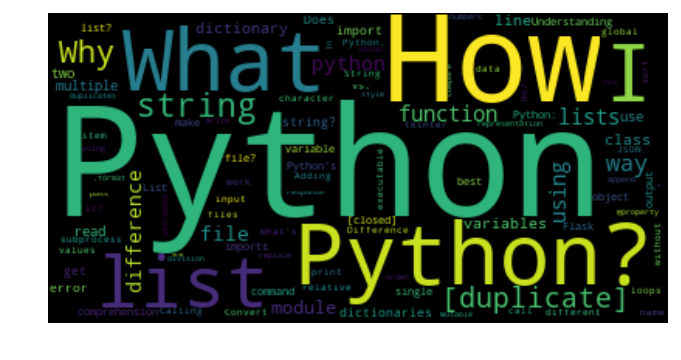

In [30]:
python_word_frequencies = {word: frequency for word, frequency in so_counter.most_common(100)}

wordcloud = WordCloud()
wordcloud.generate_from_frequencies(frequencies=python_word_frequencies)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Getting there, but still needs some work!  Let's add some new words to the stop words list.  Let's make them all lower-case and then start lower-casing on our filter, too.

#### Word Cloud #3: Updated with domain expertise

In [38]:
SO_stopwords = [
    'python', 
    'python?', 
    'using',
    'how',
    'what',
    'why',
    'how',
    'way',
    '[closed]',
    '[duplicate]',
]

Python_stopwords = set(stopwords.words('english') + SO_stopwords)

print(Python_stopwords)

set([u'all', u'just', u"don't", u'being', u'over', u'both', u'through', u'yourselves', u'its', u'before', u'o', u'don', u'hadn', u'herself', u'll', u'had', u'should', u'to', u'only', u'won', u'under', u'ours', u'has', u"should've", u"haven't", u'do', u'them', u'his', u'very', 'python?', u"you've", u'they', u'not', u'during', u'now', u'him', u'nor', u"wasn't", u'd', u'did', u'didn', u'this', '[duplicate]', u'she', u'each', u'further', u"won't", u'where', u"mustn't", u"isn't", u'few', u'because', u"you'd", u'doing', u'some', u'hasn', u"hasn't", u'are', u'our', u'ourselves', u'out', u'what', u'for', u"needn't", u'below', u're', u'does', u"shouldn't", u'above', u'between', u'mustn', u't', u'be', u'we', u'who', u"mightn't", u"doesn't", u'were', u'here', u'shouldn', u'hers', u"aren't", u'by', u'on', u'about', u'couldn', u'of', u"wouldn't", u'against', u's', u'isn', u'or', u'own', u'into', u'yourself', u'down', u"hadn't", u'mightn', u"couldn't", u'wasn', u'your', u"you're", u'from', u'her', u

Now let's see where we are:

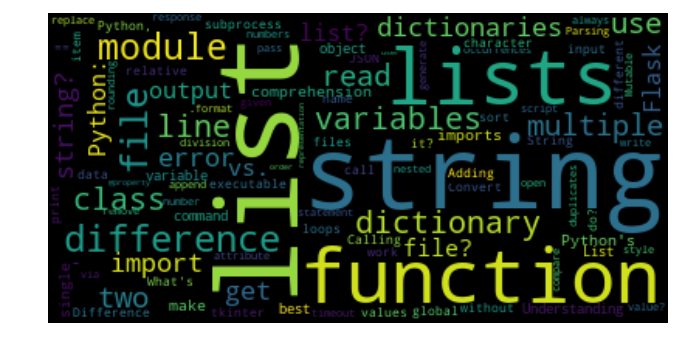

In [39]:
so_counter = Counter([word for word in SO_words if word.lower() not in Python_stopwords])

python_word_frequencies = {word: frequency for word, frequency in so_counter.most_common(100)}

wordcloud = WordCloud()
wordcloud.generate_from_frequencies(frequencies=python_word_frequencies)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

That's more like it!  What can we gather from this, in terms of both improvements and business intelligence?

1. Improvement: 'string' and 'string?' counts should be combined.  'Python?' and 'Python:' are still on the list.  This means we need to work on parsing out punctuation.  
2. Improvement: This is a minimal amount of data.  We could make the axes mean something, e.g. the X-axis be year and the Y-axis be frequency.  This would allow us to see the evolution of questions over time.
3. People struggle with data types, particularly lists and dictionaries.

#### Word Cloud #4: Split-Apply-Combine With Pandas

In [95]:
df_words = pd.DataFrame(columns=['word', 'score'])

x = -1
 
for i, row in df.iterrows():
    words = row.text.split(" ")
    score = float(row.views) + float(row.votes)
    for word in words:
        if word.lower() not in Python_stopwords:
            x = x + 1 
            print x
            df_words.loc[x] = [word, score]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [101]:
grouped_by_word = df_words.groupby('word')

In [119]:
for name, group in grouped_by_word:
    if name == "==":
        print(name)
        print(group)

==
    word      score
75    ==  1481614.0
132   ==     9220.0
979   ==   779438.0


In [124]:
scores = grouped_by_word.agg('sum')

In [135]:
print(scores.loc['=='])
print("----------------")
top_100 = scores.sort_values('score')[-100:]

score    2270272.0
Name: ==, dtype: float64
----------------


OK, so let's put all of this together in a new word cloud:

In [157]:
for i, score in top_100.iterrows():
    print(i)
    print(score.score)

concatenate
1158883.0
space?
1166877.0
newline
1166877.0
operator?
1183307.0
conditional
1183307.0
ternary
1183307.0
duplicates
1186992.0
make
1190284.0
Python:
1305895.0
relative
1306315.0
character
1325969.0
two-dimensional
1335882.0
define
1335882.0
array
1335882.0
count
1346026.0
output
1365543.0
super()
1367286.0
__init__()
1371240.0
Correct
1397317.0
Python's
1397982.0
class
1409990.0
Convert
1432790.0
string?
1448881.0
single
1468241.0
__name__
1481614.0
“__main__”:
1481614.0
datetime
1488994.0
print
1518440.0
IDE
1537562.0
“yield”
1573030.0
get
1576019.0
without
1628268.0
value?
1663539.0
Limiting
1676764.0
decimal
1676764.0
points
1676764.0
Parsing
1712349.0
split
1768659.0
floats
1771077.0
Converting
1794302.0
copy
1829150.0
write
1872674.0
keyword
1892974.0
extend
1921159.0
different
1921177.0
directory?
2021808.0
difference
2038875.0
pip
2098124.0
Windows?
2098124.0
install
2098124.0
Finding
2144751.0
containing
2144751.0
JSON
2149720.0
module
2157842.0
'contains'
2161066.0

{u'two-dimensional': 1335882.0, u'duplicates': 1186992.0, u'global': 2425537.0, u'datetime': 1488994.0, u'Understanding': 2684188.0, u'directory?': 2021808.0, u'character': 1325969.0, u'whether': 2502532.0, u'do?': 3748519.0, u'string': 9460525.0, u'get': 1576019.0, u'==': 2270272.0, u'\u201cyield\u201d': 1573030.0, u'difference': 2038875.0, u'space?': 1166877.0, u'decimal': 1676764.0, u'dictionaries': 3907458.0, u'Parse': 2659282.0, u'item': 2943141.0, u'Converting': 1794302.0, u'function': 3767904.0, u'methods': 3098496.0, u'exists': 2502532.0, u'list': 12350455.0, u'conditional': 1183307.0, u'module': 2157842.0, u'relative': 1306315.0, u'Finding': 2144751.0, u'Windows?': 2098124.0, u'append': 2995351.0, u'index': 3275357.0, u'\u201c__main__\u201d:': 1481614.0, u'Python:': 1305895.0, u'print': 1518440.0, u'concatenate': 1158883.0, u'extend': 1921159.0, u'method?': 2161066.0, u'given': 2639862.0, u'Limiting': 1676764.0, u'output': 1365543.0, u'__name__': 1481614.0, u'vs.': 3640756.0, 

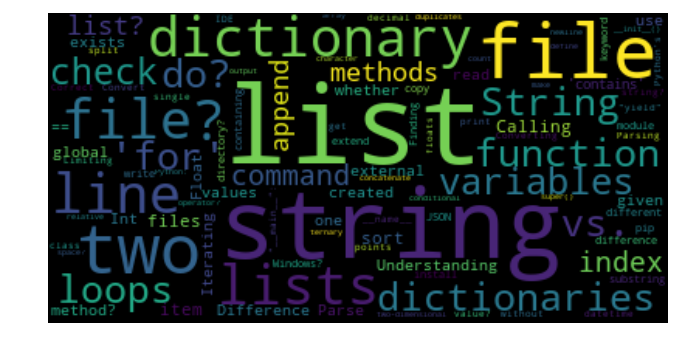

In [164]:
frequencies = {i: word.score  for i, word in top_100.iterrows() }

print(frequencies)

wordcloud = WordCloud()
wordcloud.generate_from_frequencies(frequencies=frequencies)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Exploratory Data Analysis: Tag Networks

In [211]:
import networkx as nx

G = nx.Graph()

In [212]:
import itertools

# slice off the Python in each one of these
tags = [row.tags[1:] for i, row in df.iterrows()]

x = 0

for question_tags in tags:
    
    if x < 15:
        for tag in question_tags:
            G.add_node(tag)

        for tag1, tag2 in itertools.combinations(question_tags, 2):
            G.add_edge(tag1, tag2)
        
        x = x + 1




# G.add_node('python')
# G.add_node('lists')
# G.add_node('dictionary')
# G.add_node('moopal')
# G.add_node('python')
# G.add_node('python')
# G.add_node('python')
# G.add_node('python')
# G.add_node('python')
# G.add_node('python')
# G.add_edge('python', 'python')


# G.add_edge('moopal', 'dictionary')

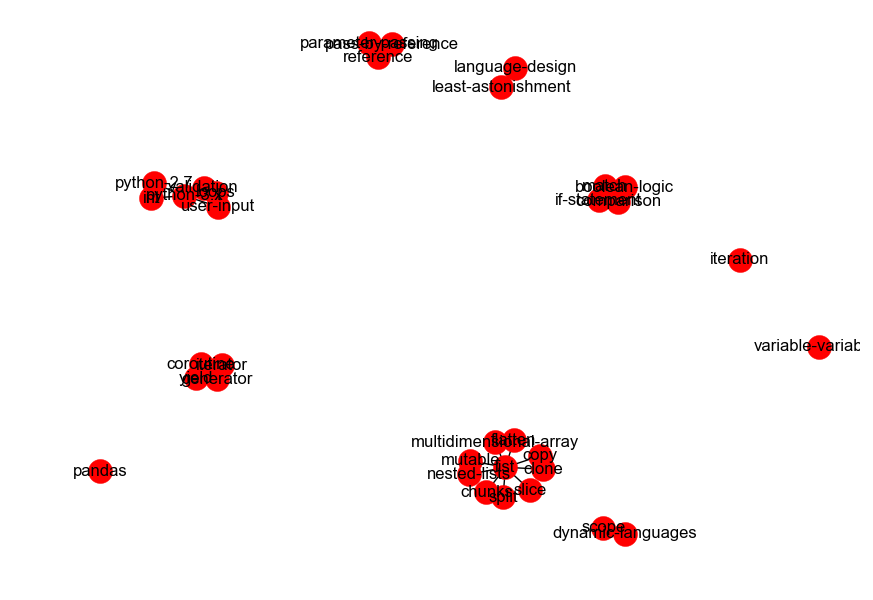

In [213]:
nx.draw(G, with_labels=True)
# df

This is very cluttered.